In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from math import cos
import numba
import random
from numba import njit
import torch
import torch.nn as nn
import time
import torchvision
from scipy.ndimage import convolve, generate_binary_structure
print("Import Done")

Import Done


In [2]:
start = time.time()

In [3]:
class ffnn(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(ffnn,self).__init__()
        self.input_size= input_size
        self.l1= nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.sigmoid(out)
        return out

In [4]:
L =  int(input("Enter the state size: "))

Enter the state size: 4


In [5]:
model = ffnn(2*L,2*L,1)

In [6]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

l1.weight tensor([[ 0.1191,  0.1054, -0.0536,  0.1855, -0.2924, -0.3263, -0.1396,  0.1837],
        [-0.0998,  0.1032, -0.2407, -0.2039, -0.0652, -0.0113,  0.2923, -0.2786],
        [-0.1562,  0.2342, -0.1255,  0.0441, -0.0617, -0.1029,  0.1960, -0.0328],
        [ 0.0536,  0.3524,  0.1310, -0.3500,  0.1522,  0.3184, -0.0879, -0.0567],
        [-0.3046, -0.1490,  0.1395,  0.1157, -0.2530, -0.3535,  0.0904, -0.1003],
        [ 0.1926, -0.2048, -0.1149, -0.1754, -0.2261,  0.1572,  0.3282, -0.1402],
        [-0.2981, -0.1179, -0.2099, -0.0176, -0.1544,  0.0577,  0.0446, -0.1603],
        [ 0.0651,  0.0808,  0.0168, -0.1119, -0.0060,  0.2438, -0.1799, -0.1736]])
l1.bias tensor([-0.2822,  0.2486,  0.3242,  0.0890,  0.2832,  0.0682,  0.1415,  0.2651])
l2.weight tensor([[ 0.2999,  0.0932,  0.3363,  0.1627,  0.3245, -0.2470, -0.0671, -0.0711]])
l2.bias tensor([-0.0013])


In [7]:
def in_state(L):
    in_state = torch.tensor(np.zeros((2*L)), dtype= torch.double)
    x,y = random.sample(range(0,L),k=2)
    a,b = random.sample(range(L,2*L),k=2)
    in_state[x] = in_state[y]= in_state[a] = in_state[b]= 1
    return in_state

In [8]:
initial_state = in_state(L)
initial_state


tensor([1., 1., 0., 0., 0., 1., 1., 0.], dtype=torch.float64)

in_state = torch.tensor(np.zeros((2*L)), dtype= torch.double) #creating 1D lattice with given size
in_state

x,y = random.sample(range(0,L),k=2)
a,b = random.sample(range(L,2*L),k=2)
in_state[x] = in_state[y]= in_state[a] = in_state[b]= 1

in_state

In [9]:
model(initial_state.float())

tensor([0.5413], grad_fn=<SigmoidBackward0>)

In [10]:
def gen_next_upspin(state):
    psi_current = model(state.float())
    next_state = torch.tensor(np.zeros((2*L)), dtype= torch.double) #creating 1D lattice with given size
    next_state[L:2*L] = state[L:2*L]
    #print("initial next state: ",next_state)
    
    while True:  
        x,y = random.sample(range(0,L), k=2)
        next_state[x] = next_state[y] =1
        if torch.equal(state,next_state)== False:
            break
    #print('final next state: ',next_state)
    psi_next = model(next_state.float())
    
    ratio = psi_next/psi_current 
    #print('ratio: ',ratio)
    prob = (abs(ratio))**2
    #print('Probability :',prob)
    a = random.random()
    #print("a: ",a)
    if a<prob:
        # Accept the new state
        return next_state
    else:
        return state
        
        

In [11]:
def gen_next_downspin(state):
    next_state = torch.tensor(np.zeros((2*L)), dtype= torch.double)
    next_state[0:L] = state[0:L]
    #print('Initial next state: ',next_state)
    while True:  
        x,y = random.sample(range(L,2*L), k=2)
        next_state[x] = next_state[y] =1
        if torch.equal(state,next_state)== False:
            break
    #print('Final next state: ',next_state)
    ratio = model(next_state.float())/model(state.float()) 
    #print('ratio: ',ratio)
    prob = (abs(ratio))**2
    #print('Probability: ',prob)
    a = random.random()
    #print('a: ',a)
    if a<prob:
        # Accept the new state
        return next_state
    else:
        return state

In [12]:
state_up= gen_next_upspin(initial_state)
state_up

tensor([1., 0., 1., 0., 0., 1., 1., 0.], dtype=torch.float64)

In [13]:
state_down = gen_next_downspin(initial_state)
state_down

tensor([1., 1., 0., 0., 1., 0., 0., 1.], dtype=torch.float64)

In [14]:
initial_state

tensor([1., 1., 0., 0., 0., 1., 1., 0.], dtype=torch.float64)

In [15]:
t = 1
U= 0


In [16]:
def mc_state(state):
    for i in range(0,L):
        state = gen_next_upspin(state)
    for i in range(0,L):
        state = gen_next_downspin(state)
        
    return state
    

In [17]:
def get_kin_energy_up(state,t):
    sum = 0
    kern= torch.tensor([1,1])
    psi_in = model(state.float())
    arr= convolve(state[0:L],kern,mode = 'wrap')
    for i in range(L):
        if arr[i]==1:
            if i != L-1:
                hopping_state = state.clone() 
                hopping_state[i],hopping_state[i+1]= state[i+1],state[i]
                sum+= (model(hopping_state.float())/psi_in)
                #print('sum: ',sum)
            elif i== L-1:
                hopping_state = state.clone() 
                hopping_state[i],hopping_state[0]= state[0],state[i]
                sum+= (model(hopping_state.float())/psi_in)
                #print('sum: ',sum)
    return -t*sum

In [18]:
def get_kin_energy_down(state,t):
    sum = 0
    kern = torch.tensor([1,1])
    psi_in = model(state.float())
    arr = convolve(state[L:2*L],kern,mode = 'wrap')
    for i in range(L):
        if arr[i] ==1:
            if i!= L-1:
                hopping_state= state.clone()
                hopping_state[i+L],hopping_state[i+L+1]= state[i+L+1],state[i+L]
                ratio = model(hopping_state.float())/psi_in
                sum+=ratio
            elif i==L-1:
                hopping_state = state.clone()
                hopping_state[i+L],hopping_state[L]= state[L],state[i+L]
                ratio= model(hopping_state.float())/psi_in
                sum+=ratio
    return -t*sum

In [19]:
state = torch.tensor([0.,1.,0.,1.,1.,0.,0.,1.])
state

tensor([0., 1., 0., 1., 1., 0., 0., 1.])

In [20]:
get_kin_energy_up(state,t)

tensor([-3.8865], grad_fn=<MulBackward0>)

In [21]:
get_kin_energy_down(state,t)

tensor([-2.0586], grad_fn=<MulBackward0>)

In [22]:
def kinetic_energy(state,t):
    return (get_kin_energy_up(state,t) + get_kin_energy_down(state,t))

In [23]:
kinetic_energy(state,t)

tensor([-5.9451], grad_fn=<AddBackward0>)

In [24]:
def interaction_energy(state,U):
    sum = 0
    for i in range(L):
        if state[i] ==1 and state[i+L]==1:
            sum+=1
    return U*sum

In [25]:
def get_total_energy(state,t,U):
    return (kinetic_energy(state,t) + interaction_energy(state,U))

In [26]:
get_total_energy(state,t,U)

tensor([-5.9451], grad_fn=<AddBackward0>)

In [27]:
def run_mc_sim():
    energy = 0
    state = in_state(L)
    mc_step = 1000
    warm_step = 1000
    for i in range(0,warm_step):
        state = mc_state(state)
        #print(state)
        
        
    for i in range(0,mc_step):
        state = mc_state(state)
        en = get_total_energy(state,t,U)/L
        energy+= en
    return energy/mc_step

In [28]:
y= run_mc_sim()
Ene= y.detach().numpy()[0]

In [29]:
y

tensor([-1.2578], grad_fn=<DivBackward0>)

In [30]:
run_mc_sim().detach().numpy()[0]

-1.2465034

# Genetic optimization of NN

In [31]:
import pygad.torchga as ga
import pygad

In [32]:
torch_ga = ga.TorchGA(model = model,
                     num_solutions=10)  # constructing TorchGa class


In [33]:
e_ref = -5.0

In [34]:
def fitness(solution,sol_idx):
    global torch_ga,model
    model_weights_dict = ga.model_weights_as_dict(model= model,
                                                 weights_vector=solution)
    
    model.load_state_dict(model_weights_dict)
    
    #fitness = 1.0/(get_total_energy(state,t,U).detach().numpy()[0]  + 0.0001)
    energy = run_mc_sim().detach().numpy()[0] - e_ref
    fitness = 1.0/(energy)
    return fitness

In [35]:
def optimal_enenrgy(fitness_val):
    return (1/fitness_val) + e_ref

In [36]:
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    fitness=ga_instance.best_solution()[1]
    print("Fitness    = {}".format(fitness))
    print("Energy = {}".format(optimal_enenrgy(fitness)))

In [37]:
num_generations = 200
num_parents_mating = 5
initial_population = torch_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness,
                       on_generation=callback_generation)

In [38]:
ga_instance.run()

Generation = 1
Fitness    = 0.26887439667907137
Energy = -1.280791282653809
Generation = 2
Fitness    = 0.2692439460290391
Energy = -1.2858960628509517
Generation = 3
Fitness    = 0.26957907513570367
Energy = -1.290513277053833
Generation = 4
Fitness    = 0.26957907513570367
Energy = -1.290513277053833
Generation = 5
Fitness    = 0.2704505593178279
Energy = -1.3024665117263794
Generation = 6
Fitness    = 0.2709221222852143
Energy = -1.3089023828506474
Generation = 7
Fitness    = 0.2709221222852143
Energy = -1.3089023828506474
Generation = 8
Fitness    = 0.2709221222852143
Energy = -1.3089023828506474
Generation = 9
Fitness    = 0.2709221222852143
Energy = -1.3089023828506474
Generation = 10
Fitness    = 0.2709221222852143
Energy = -1.3089023828506474
Generation = 11
Fitness    = 0.2709221222852143
Energy = -1.3089023828506474
Generation = 12
Fitness    = 0.2709221222852143
Energy = -1.3089023828506474
Generation = 13
Fitness    = 0.2709221222852143
Energy = -1.3089023828506474
Generati

Generation = 108
Fitness    = 0.27228325845166773
Energy = -1.327354073524475
Generation = 109
Fitness    = 0.27228325845166773
Energy = -1.327354073524475
Generation = 110
Fitness    = 0.27228325845166773
Energy = -1.327354073524475
Generation = 111
Fitness    = 0.27228325845166773
Energy = -1.327354073524475
Generation = 112
Fitness    = 0.27228325845166773
Energy = -1.327354073524475
Generation = 113
Fitness    = 0.27228325845166773
Energy = -1.327354073524475
Generation = 114
Fitness    = 0.27244231968405735
Energy = -1.329498291015625
Generation = 115
Fitness    = 0.27244231968405735
Energy = -1.329498291015625
Generation = 116
Fitness    = 0.27244231968405735
Energy = -1.329498291015625
Generation = 117
Fitness    = 0.27244231968405735
Energy = -1.329498291015625
Generation = 118
Fitness    = 0.27244231968405735
Energy = -1.329498291015625
Generation = 119
Fitness    = 0.27244231968405735
Energy = -1.329498291015625
Generation = 120
Fitness    = 0.27244231968405735
Energy = -1.32

/home/ashuworld/pythonenv/lib/python3.9/site-packages/pygad/pygad.py:3591: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


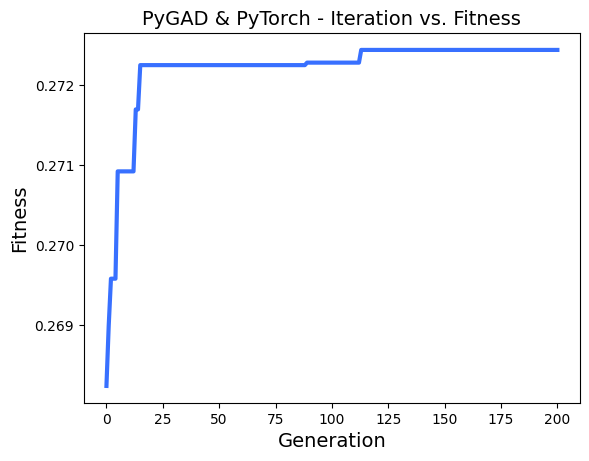

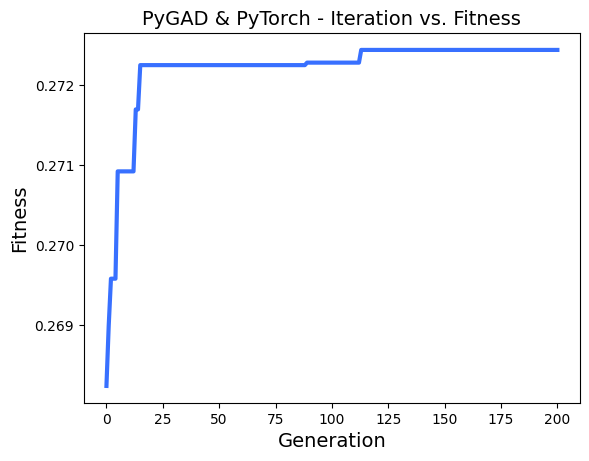

In [39]:
ga_instance.plot_result(title="PyGAD & PyTorch - Iteration vs. Fitness")

In [40]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
#print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

Fitness value of the best solution = 0.27244231968405735


In [41]:
!date

Sun Apr 23 13:01:27 IST 2023


run start 22-04-2023 15:31 PM



Total time 8hrs 45 min

In [42]:
optimal_enenrgy(solution_fitness)

-1.329498291015625

In [43]:
# Fetch the parameters of the best solution.
best_solution_weights = ga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)



In [44]:
best_solution_weights

OrderedDict([('l1.weight',
              tensor([[ 0.4738, -0.5669, -0.2731, -0.5051, -0.3506,  0.6277, -1.1123,  0.9040],
                      [-1.7454,  0.3044,  0.0508, -0.1689,  0.1799, -1.1318,  0.7304,  0.0674],
                      [ 0.0695,  0.6612, -1.0533,  0.1426, -1.1694,  0.6912, -1.2660,  0.0189],
                      [ 0.0917, -0.4674,  0.6131, -1.6350, -0.3189, -0.9494, -0.9618, -1.9268],
                      [ 0.9367, -1.7500,  1.2851, -0.8862,  0.2624, -0.6812,  0.7167, -0.5921],
                      [ 0.6826, -1.3785, -0.4515, -1.0355, -1.3705,  0.1939,  0.9392,  1.4874],
                      [ 0.4118, -1.5115, -2.9693, -0.1905, -0.9645,  0.0786, -0.1626, -0.0755],
                      [ 0.9463, -0.0648,  0.5473, -0.1374, -0.4747,  0.5443,  0.8452, -2.1273]],
                     dtype=torch.float64)),
             ('l1.bias',
              tensor([-1.1652,  0.6446,  0.4243,  0.9771, -0.1360,  0.0088, -0.0627, -0.4123],
                     dtype=torch.float64

In [45]:
end = time.time()
print((end-start)/3600)

8.73252216802703


# Gradient Based Optimization

In [46]:
from torch.functional import F

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [48]:
loss_lst = []
y= torch.tensor([-2.0])
for i in range(100):
    pred = model(state.float())#.detach().numpy()[0]
    loss = F.mse_loss(pred, y).sqrt()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_lst.append(loss)

In [49]:
print(loss_lst)

[tensor(2.9855, grad_fn=<SqrtBackward0>), tensor(2.9853, grad_fn=<SqrtBackward0>), tensor(2.9850, grad_fn=<SqrtBackward0>), tensor(2.9848, grad_fn=<SqrtBackward0>), tensor(2.9845, grad_fn=<SqrtBackward0>), tensor(2.9842, grad_fn=<SqrtBackward0>), tensor(2.9840, grad_fn=<SqrtBackward0>), tensor(2.9837, grad_fn=<SqrtBackward0>), tensor(2.9834, grad_fn=<SqrtBackward0>), tensor(2.9832, grad_fn=<SqrtBackward0>), tensor(2.9829, grad_fn=<SqrtBackward0>), tensor(2.9826, grad_fn=<SqrtBackward0>), tensor(2.9823, grad_fn=<SqrtBackward0>), tensor(2.9820, grad_fn=<SqrtBackward0>), tensor(2.9817, grad_fn=<SqrtBackward0>), tensor(2.9814, grad_fn=<SqrtBackward0>), tensor(2.9811, grad_fn=<SqrtBackward0>), tensor(2.9807, grad_fn=<SqrtBackward0>), tensor(2.9804, grad_fn=<SqrtBackward0>), tensor(2.9801, grad_fn=<SqrtBackward0>), tensor(2.9797, grad_fn=<SqrtBackward0>), tensor(2.9794, grad_fn=<SqrtBackward0>), tensor(2.9790, grad_fn=<SqrtBackward0>), tensor(2.9787, grad_fn=<SqrtBackward0>), tensor(2.9783, 

In [50]:
x = torch.arange(100)
print(x)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


In [51]:
print(type(x))

<class 'torch.Tensor'>


In [52]:
y = 2*np.exp(-1*x)+2.0
print(y)

tensor([4.0000, 2.7358, 2.2707, 2.0996, 2.0366, 2.0135, 2.0050, 2.0018, 2.0007,
        2.0002, 2.0001, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000], dtype=torch.float64)


In [53]:
print(type(y))

<class 'torch.Tensor'>


In [54]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

l1.weight tensor([[-0.1745, -1.2428, -0.5439, -0.0219, -0.4574,  0.6277, -1.4832,  0.9040],
        [-2.6111,  0.1794,  0.0508, -0.2939,  0.6691, -1.1318,  0.7304, -0.0576],
        [ 0.2734,  0.1205, -1.4821,  0.0165, -0.4689,  1.1590, -1.2022,  0.4495],
        [ 0.3516, -0.8430,  0.0086, -1.3763,  0.5593, -1.6547, -1.2375, -2.3423],
        [ 1.8034, -2.1129,  1.2851, -0.8862,  0.2624, -1.4263,  1.1800, -0.5921],
        [ 0.7409, -1.3785, -0.4515, -0.3381, -2.1890,  1.2188,  1.2141,  1.4874],
        [ 0.4118, -0.8483, -2.5510, -0.1905, -0.4629,  0.0786,  0.4792, -0.0755],
        [ 0.2360, -0.9076,  0.8697, -0.1374, -0.5945, -0.0686,  0.8452, -2.1273]])
l1.bias tensor([-1.8643,  1.3899,  0.5038,  1.8952, -0.1360,  0.2490,  0.3878, -0.4514])
l2.weight tensor([[2.3246, 0.6844, 1.5120, 0.6770, 2.3382, 0.1456, 0.2288, 0.7764]])
l2.bias tensor([0.0223])


In [55]:
run_mc_sim()

tensor([-1.3014], grad_fn=<DivBackward0>)

In [56]:
import time

In [57]:
x = time.time()

In [58]:
y = time.time()

In [59]:
print(y-x)

0.009889841079711914
